In [2]:
# Authentication for loading data from Google Drive
# Import packages
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
from os import path

In [3]:
# Authenticate User
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
auth_drive = GoogleDrive(gauth)

In [4]:
DRIVE_PATH = '/content/drive'
drive.mount(DRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
DATA_PATH = path.join(DRIVE_PATH, 'My Drive', 'LinkedIn_Articles', 'Datasets', 'ISIC_Skin_Cancer')
OUTPUT_PATH = path.join(DRIVE_PATH, 'My Drive', 'LinkedIn_Articles', 'Multiple Inputs')

In [6]:
# Import necessary packages
import numpy as np
import pandas as pd
import glob # I use glob instead of ls due to double quote vs ls command on Colab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread

# Import Keras for Neural Networks
from keras import Model
from keras import Input
from keras import layers
from keras import losses
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import load_model

In [7]:
df_train_truth = pd.read_csv(path.join(DATA_PATH, 'ISIC_2019_Training_GroundTruth.csv'))
df_train_meta = pd.read_csv(path.join(DATA_PATH, 'ISIC_2019_Training_Metadata.csv'))

In [8]:
df_train_truth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB


In [9]:
df_train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB


In [10]:
df_train = pd.concat([df_train_meta, df_train_truth], axis=1)

In [11]:
df_train = df_train.iloc[:,~df_train.columns.duplicated()]

In [12]:
df_train

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Check na for useful columns
print(df_train.image.isna().unique())
print(df_train.age_approx.isna().unique())
print(df_train.anatom_site_general.isna().unique())
print(df_train.sex.isna().unique())

print(df_train.MEL.isna().unique())
print(df_train.NV.isna().unique())
print(df_train.BCC.isna().unique())
print(df_train.AK.isna().unique())

print(df_train.BKL.isna().unique())
print(df_train.DF.isna().unique())
print(df_train.VASC.isna().unique())
print(df_train.SCC.isna().unique())
print(df_train.UNK.isna().unique())

[False]
[False  True]
[False  True]
[False  True]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


In [14]:
age_mean = df_train.age_approx.mean()
replacement_values = {'age_approx': age_mean, 'anatom_site_general': 'Unknown', 'sex': 'Unknown'}

In [15]:
df_train = df_train.fillna(value=replacement_values)

In [16]:
df_required = df_train[['image', 'age_approx','anatom_site_general','sex','MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']]
df_required = pd.get_dummies(df_required, prefix=['anatom_site_general', 'sex'], columns=['anatom_site_general', 'sex'])
df_required['MEL'] = pd.to_numeric(df_required['MEL'], downcast='unsigned')
df_required['NV'] = pd.to_numeric(df_required['NV'], downcast='unsigned')
df_required['BCC'] = pd.to_numeric(df_required['BCC'], downcast='unsigned')
df_required['AK'] = pd.to_numeric(df_required['AK'], downcast='unsigned')
df_required['BKL'] = pd.to_numeric(df_required['BKL'], downcast='unsigned')
df_required['DF'] = pd.to_numeric(df_required['DF'], downcast='unsigned')
df_required['VASC'] = pd.to_numeric(df_required['VASC'], downcast='unsigned')
df_required['SCC'] = pd.to_numeric(df_required['SCC'], downcast='unsigned')
df_required['UNK'] = pd.to_numeric(df_required['UNK'], downcast='unsigned')
df_required

,image,age_approx,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,anatom_site_general_Unknown,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_oral/genital,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_upper extremity,sex_Unknown,sex_female,sex_male
0,ISIC_0000000,55.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,ISIC_0000001,30.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,ISIC_0000002,60.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,ISIC_0000003,30.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,ISIC_0000004,80.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
25327,ISIC_0073248,65.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
25328,ISIC_0073249,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
25329,ISIC_0073251,55.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [17]:
df_required.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image                                25331 non-null  object 
 1   age_approx                           25331 non-null  float64
 2   MEL                                  25331 non-null  uint8  
 3   NV                                   25331 non-null  uint8  
 4   BCC                                  25331 non-null  uint8  
 5   AK                                   25331 non-null  uint8  
 6   BKL                                  25331 non-null  uint8  
 7   DF                                   25331 non-null  uint8  
 8   VASC                                 25331 non-null  uint8  
 9   SCC                                  25331 non-null  uint8  
 10  UNK                                  25331 non-null  uint8  
 11  anatom_site_general_Unknown 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_required.drop('MEL', axis=1), 
                                                    df_required[['MEL']], test_size=0.2, random_state=20200803)

In [19]:
IMAGE_SHAPE = (128, 128, 3)
BATCH_SIZE = 128

In [20]:
def get_image_batch(source, current_index, batch_size=BATCH_SIZE, image_shape=IMAGE_SHAPE):
  start_index = current_index * batch_size
  end_index = start_index + batch_size
  source_slice = source.iloc[start_index:end_index]
  batch_images = []
  for piece in source_slice:
    img = imread(DATA_PATH + '/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + piece + '.jpg')
    img = resize(img, image_shape)
    batch_images.append(img)
  batch_images = np.asarray(batch_images)
  return batch_images

In [21]:
def get_categorical_batch(source, current_index, batch_size=BATCH_SIZE):
  start_index = current_index * batch_size
  end_index = start_index + batch_size
  source_slice = source.iloc[start_index:end_index]

  return source_slice

In [22]:
def get_target_slice(source, current_index, batch_size=BATCH_SIZE):
  start_index = current_index * batch_size
  end_index = start_index + batch_size
  source_slice = source.iloc[start_index:end_index]

  return source_slice

In [23]:
def image_input_nn(image_shape=IMAGE_SHAPE):
  image_input = Input(shape=image_shape)

  image_nn = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(image_input)
  image_nn = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(image_nn)
  image_nn = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(image_nn)
  
  image_nn = layers.Flatten()(image_nn)

  image_nn = layers.Dense(64, activation='relu')(image_nn)
  image_nn = layers.Dense(1, activation='sigmoid')(image_nn)

  image_nn = Model(inputs=image_input, outputs=image_nn)

  return image_nn

In [24]:
def categorical_input_nn(categorical_columns):
  categorical_input = Input(shape=categorical_columns)

  categorical_nn = layers.Dense(64, activation='relu')(categorical_input)
  categorical_nn = layers.Dense(128, activation='relu')(categorical_nn)
  categorical_nn = layers.Dense(128, activation='relu')(categorical_nn)
  categorical_nn = layers.Dense(64, activation='relu')(categorical_nn)

  categorical_nn = layers.Dense(1, activation='sigmoid')(categorical_nn)

  categorical_nn = Model(inputs=categorical_input, outputs=categorical_nn)

  return categorical_nn

In [25]:
def combined_model(image_nn, categorical_nn):
  combined_input = layers.concatenate([image_nn.output, categorical_nn.output])

  combined_nn = layers.Dense(2, activation='relu')(combined_input)
  combined_nn = layers.Dense(1, activation='sigmoid')(combined_nn)

  combined_nn = Model(inputs=[image_nn.input, categorical_nn.input], outputs=combined_nn)

  return combined_nn

In [26]:
image_nn = image_input_nn(IMAGE_SHAPE)
image_nn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
flatten (Flatten)            (None, 2097152)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                134217792 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [27]:
categorical_nn = categorical_input_nn(X_train.drop(columns=['image']).columns.shape)
categorical_nn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1408      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 34,561
Trainable params: 34,561
Non-trainable params: 0
__________________________________________________

In [28]:
combined_nn = combined_model(image_nn, categorical_nn)
combined_nn.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 73856       conv2d[0][0]                     
_______________________________________________________________________________________

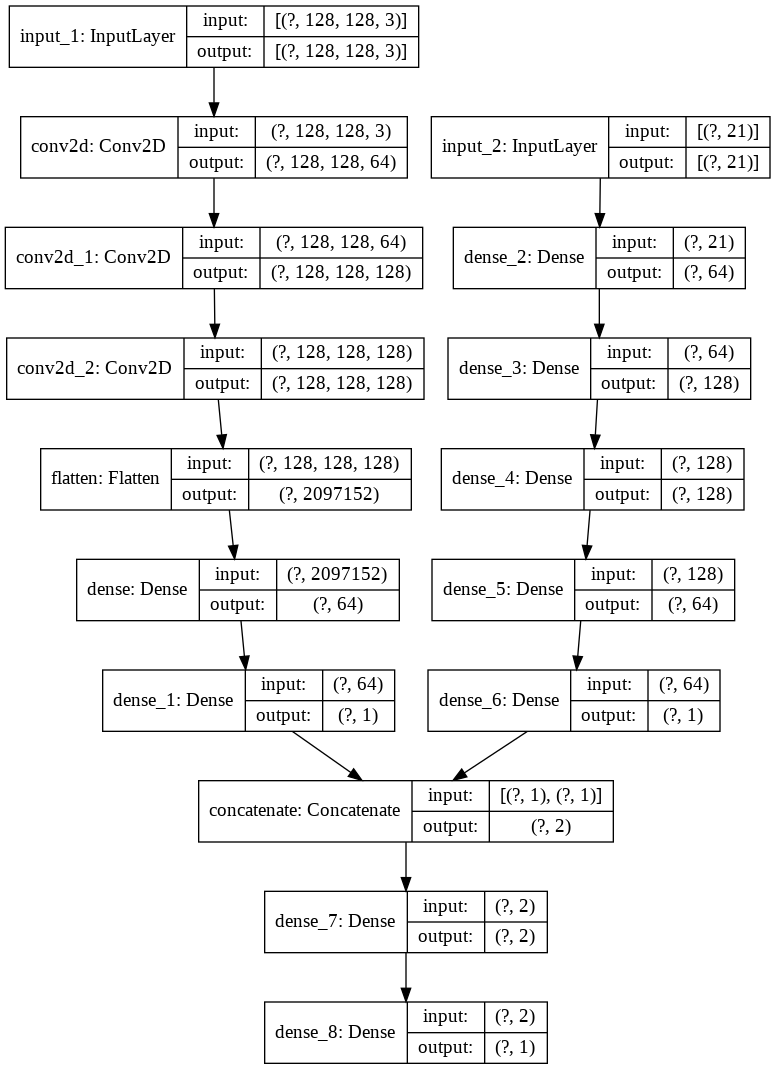

In [29]:
plot_model(combined_nn, to_file=(path.join(OUTPUT_PATH,'Multiple Inputs Model.png')), show_shapes=True, show_layer_names=True)

In [30]:
combined_nn.compile(optimizer=Adam(lr=0.001), loss=losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
# Log the output
with open(path.join(OUTPUT_PATH, 'log.csv'), 'w') as log:
  log.write('Batch_Index,Loss,Accuracy\n')

total_batches = np.floor(len(X_train) / BATCH_SIZE)
print("Total Batches:", total_batches)
for batch_index in range(int(total_batches+1)):
  image_input = get_image_batch(X_train['image'], batch_index)
  categorical_input = get_categorical_batch(X_train.drop(columns=['image']), batch_index)
  target_input = get_target_slice(y_train, batch_index)

  print('Training on batch_index:', batch_index)

  batch_train_output = combined_nn.train_on_batch([image_input, categorical_input], target_input)
  
  # Append the log after every step
  with open(path.join(OUTPUT_PATH, 'log.csv'), 'a') as log:
    log.write('%d,%f,%f\n' % (batch_index, batch_train_output[0], batch_train_output[1]))

  # Save model after some iterations
  if (((batch_index % 50) == 0) or (batch_index == total_batches)):
    combined_nn.save(path.join(OUTPUT_PATH, 'models', ('combined_nn_'+str(batch_index)+'.h5')))

Total Batches: 158.0
Training on batch_index: 0
Training on batch_index: 1
Training on batch_index: 2
Training on batch_index: 3
Training on batch_index: 4
Training on batch_index: 5
Training on batch_index: 6
Training on batch_index: 7
Training on batch_index: 8
Training on batch_index: 9
Training on batch_index: 10
Training on batch_index: 11
Training on batch_index: 12
Training on batch_index: 13
Training on batch_index: 14
Training on batch_index: 15
Training on batch_index: 16
Training on batch_index: 17
Training on batch_index: 18
Training on batch_index: 19
Training on batch_index: 20
Training on batch_index: 21
Training on batch_index: 22
Training on batch_index: 23
Training on batch_index: 24
Training on batch_index: 25
Training on batch_index: 26
Training on batch_index: 27
Training on batch_index: 28
Training on batch_index: 29
Training on batch_index: 30
Training on batch_index: 31
Training on batch_index: 32
Training on batch_index: 33
Training on batch_index: 34
Training 

In [36]:
# Test the model
# Log the output
combined_nn = load_model(path.join(OUTPUT_PATH, 'models', 'combined_nn_150.h5'))
with open(path.join(OUTPUT_PATH, 'test_log_150.csv'), 'w') as log:
  log.write('Batch_Index,Loss,Accuracy\n')

total_batches = np.floor(len(X_test) / BATCH_SIZE)
print("Total Batches:", total_batches)
for batch_index in range(int(total_batches+1)):
  image_input = get_image_batch(X_test['image'], batch_index)
  categorical_input = get_categorical_batch(X_test.drop(columns=['image']), batch_index)
  target_input = get_target_slice(y_test, batch_index)

  print('Testing on batch_index:', batch_index)

  batch_test_output = combined_nn.test_on_batch([image_input, categorical_input], target_input)
  
  # Append the log after every step
  with open(path.join(OUTPUT_PATH, 'test_log_150.csv'), 'a') as log:
    log.write('%d,%f,%f\n' % (batch_index, batch_test_output[0], batch_test_output[1]))

Total Batches: 39.0
Testing on batch_index: 0
Testing on batch_index: 1
Testing on batch_index: 2
Testing on batch_index: 3
Testing on batch_index: 4
Testing on batch_index: 5
Testing on batch_index: 6
Testing on batch_index: 7
Testing on batch_index: 8
Testing on batch_index: 9
Testing on batch_index: 10
Testing on batch_index: 11
Testing on batch_index: 12
Testing on batch_index: 13
Testing on batch_index: 14
Testing on batch_index: 15
Testing on batch_index: 16
Testing on batch_index: 17
Testing on batch_index: 18
Testing on batch_index: 19
Testing on batch_index: 20
Testing on batch_index: 21
Testing on batch_index: 22
Testing on batch_index: 23
Testing on batch_index: 24
Testing on batch_index: 25
Testing on batch_index: 26
Testing on batch_index: 27
Testing on batch_index: 28
Testing on batch_index: 29
Testing on batch_index: 30
Testing on batch_index: 31
Testing on batch_index: 32
Testing on batch_index: 33
Testing on batch_index: 34
Testing on batch_index: 35
Testing on batch_i

In [38]:
test_log = pd.read_csv(path.join(OUTPUT_PATH, 'test_log.csv'))
print(np.average(test_log['Accuracy']))

0.8204141


In [39]:
test_log = pd.read_csv(path.join(OUTPUT_PATH, 'test_log_150.csv'))
print(np.average(test_log['Accuracy']))

0.8204141


In [43]:
def image_input_nn(image_shape):
  image_input = Input(shape=image_shape)

  image_nn = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(image_input)
  image_nn = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(image_nn)
  image_nn = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu')(image_nn)
  
  image_nn = layers.Flatten()(image_nn)

  image_nn = layers.Dense(64, activation='relu')(image_nn)
  image_nn = layers.Dense(1, activation='sigmoid')(image_nn)

  image_nn = Model(inputs=image_input, outputs=image_nn)

  return image_nn

In [41]:
def categorical_input_nn(categorical_columns):
  categorical_input = Input(shape=categorical_columns)

  categorical_nn = layers.Dense(64, activation='relu')(categorical_input)
  categorical_nn = layers.Dense(64, activation='relu')(categorical_nn)
  categorical_nn = layers.Dense(64, activation='relu')(categorical_nn)

  categorical_nn = layers.Dense(1, activation='sigmoid')(categorical_nn)

  categorical_nn = Model(inputs=categorical_input, outputs=categorical_nn)

  return categorical_nn

In [42]:
def combined_model(list_networks):
  
  list_network_inputs = []
  list_network_outputs = []
  for network in list_networks:
    list_network_inputs.append(network.input)
    list_network_outputs.append(network.output)
  
  combined_input = layers.concatenate(list_network_outputs)

  combined_nn = layers.Dense(2, activation='relu')(combined_input)
  combined_nn = layers.Dense(1, activation='sigmoid')(combined_nn)

  combined_nn = Model(inputs=list_network_inputs, outputs=combined_nn)

  return combined_nn

In [44]:
color_image_nn = image_input_nn((128,128,3))
bw_image_nn = image_input_nn((64,64,1))
cat_num_nn = categorical_input_nn((20,))
combined_network = combined_model([color_image_nn, bw_image_nn, cat_num_nn])
combined_network.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 128 3584        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 128)  1280        input_4[0][0]                    
______________________________________________________________________________________

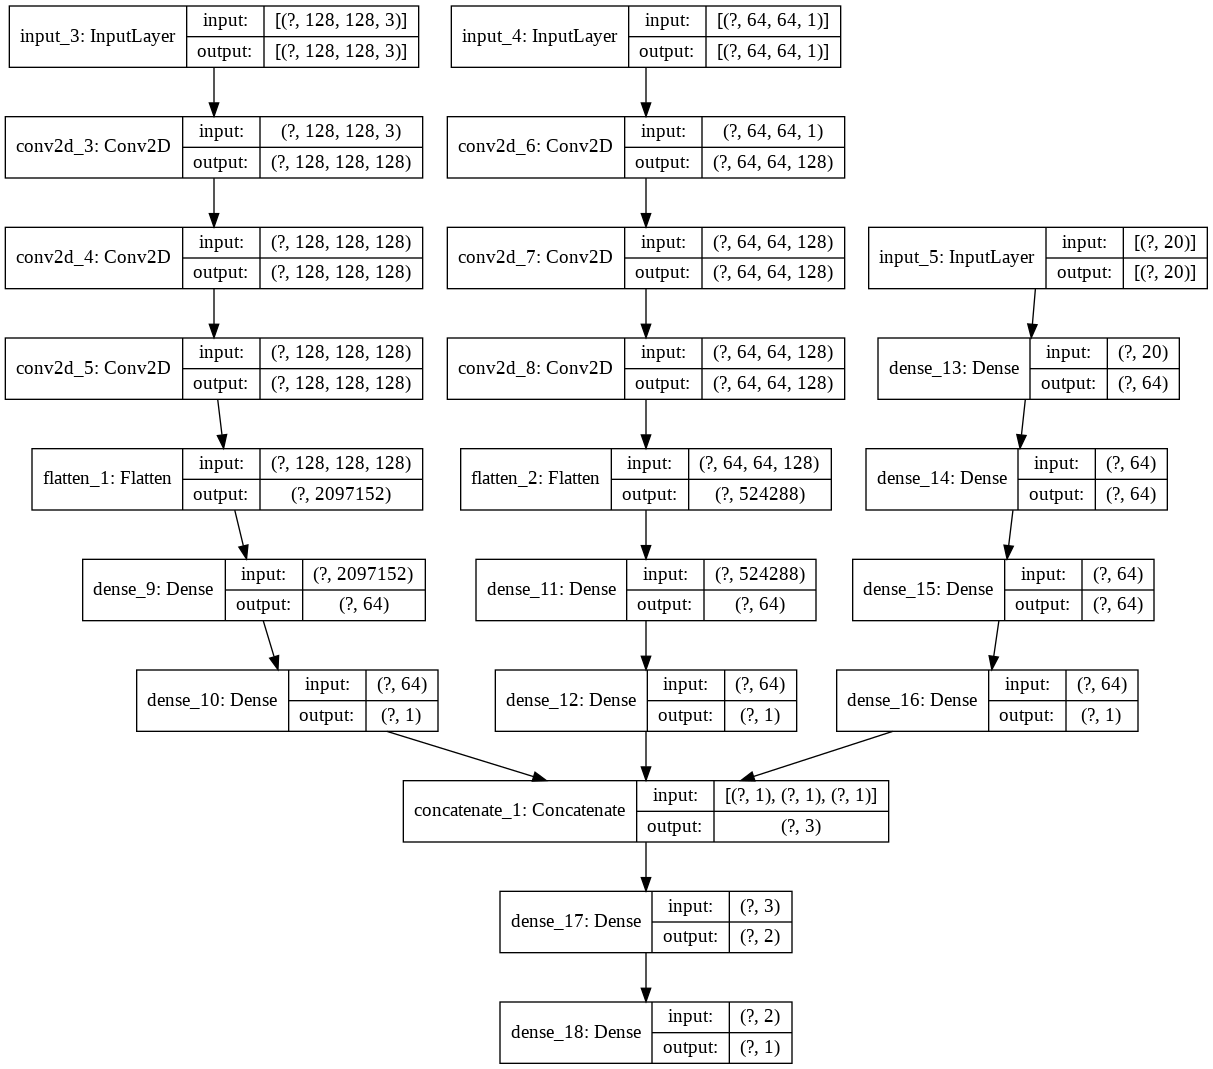

In [45]:
plot_model(combined_network, to_file=(path.join(OUTPUT_PATH,'Three Inputs Model.png')), show_shapes=True, show_layer_names=True)